<a href="https://colab.research.google.com/github/RyamAlmalki/Pixial2Prediction/blob/master/3_RESNET_Model_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification by Fine-Tuned ResNet on the CIFAR-10 Dataset

## Why This Notebook Matters!

Imagine you have thousands of images and need to sort them into categories like airplanes, dogs, or frogs. Doing it manually would be exhausting, right? That's where this notebook comes in!

Here, we'll train a computer to recognize these images for us. We'll use a pre-trained ResNet50 model, which is already really good at recognizing images, and fine-tune it to make it even better for our specific task.

### What You'll Learn:
1. How to load and explore the CIFAR-10 dataset.
2. Why preprocessing is crucial.
3. The magic of transfer learning with ResNet50.
4. How to train and evaluate an image classification model.
5. Testing the model on images outside the dataset.

By the end, you'll have a model that can classify images with impressive accuracy, and you'll understand the steps it took to get there. Let the image recognition journey begin!



## Step 1: Importing the Libraries

### Why These Libraries?

 **torch**: This is PyTorch, the backbone of our deep learning project. It helps us define, train, and evaluate neural networks.
2. **numpy**: A handy library for mathematical operations and handling arrays.
3. **random**: Adds randomness to certain operations, useful for data splitting.
4. **torchvision**: Provides tools and datasets tailored for computer vision tasks.
   - `datasets`: For accessing image datasets like CIFAR-10.
   - `transforms`: For data preprocessing and augmentation.
   - `models`: Contains pre-trained models like ResNet50.
5. **DataLoader & random_split**: For efficiently loading and splitting data into training, validation, and test sets.
6. **torch.nn and torch.optim**: For defining the model architecture and optimizing it during training.
7. **matplotlib.pyplot**: For visualizing data, loss, and accuracy trends.


In [ ]:
import torch
import numpy as np
import random
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, Subset
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

- **random_seed**: A fixed number to initialize randomness.
- **torch.manual_seed()**: Ensures all random processes in PyTorch are consistent.
- **np.random.seed()**: Makes NumPy random operations reproducible.
- **random.seed()**: Keeps Python's native random operations predictable.
- **torch.backends.cudnn**: Configures PyTorch's behavior on CUDA devices.
  - `deterministic = True`: Forces deterministic behavior.
  - `benchmark = False`: Prevents dynamic optimizations that could affect reproducibility.

By doing this, our training results will remain consistent and comparable across different runs.

## Step 2: Setting Random Seeds

### Why Set Random Seeds?

Randomness is a double-edged sword in machine learning. It helps in creating variations (e.g., during data splitting), but without control, it can make results inconsistent. By setting random seeds, we ensure that every time we run the notebook, we get the same results. It's like following a well-documented recipe to bake a cake—you know exactly how it will turn out!


In [ ]:
random_seed = 42 # Define seed value for random number generation.
torch.manual_seed(random_seed) # Sets the seed for PyTorch.
np.random.seed(random_seed) # Sets the seed for NumPy.
random.seed(random_seed) # Sets the seed for Python's random module.
# Ensures reproducibility for operations on CUDA (if available).
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

This line checks if a CUDA-enabled GPU is available. If so, it sets the device to "cuda" (GPU), otherwise, it sets it to "cpu". Then it print the chosen one.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Step 3: Loading and Exploring the Dataset

### Visualize and Analyze the CIFAR-10 Dataset

To better understand our dataset, we will visualize some random images and analyze the distribution of images across the classes.





Visualizing raw dataset:


100%|██████████| 170M/170M [00:03<00:00, 43.7MB/s]


Extracting ./data/cifar10/cifar-10-python.tar.gz to ./data/cifar10


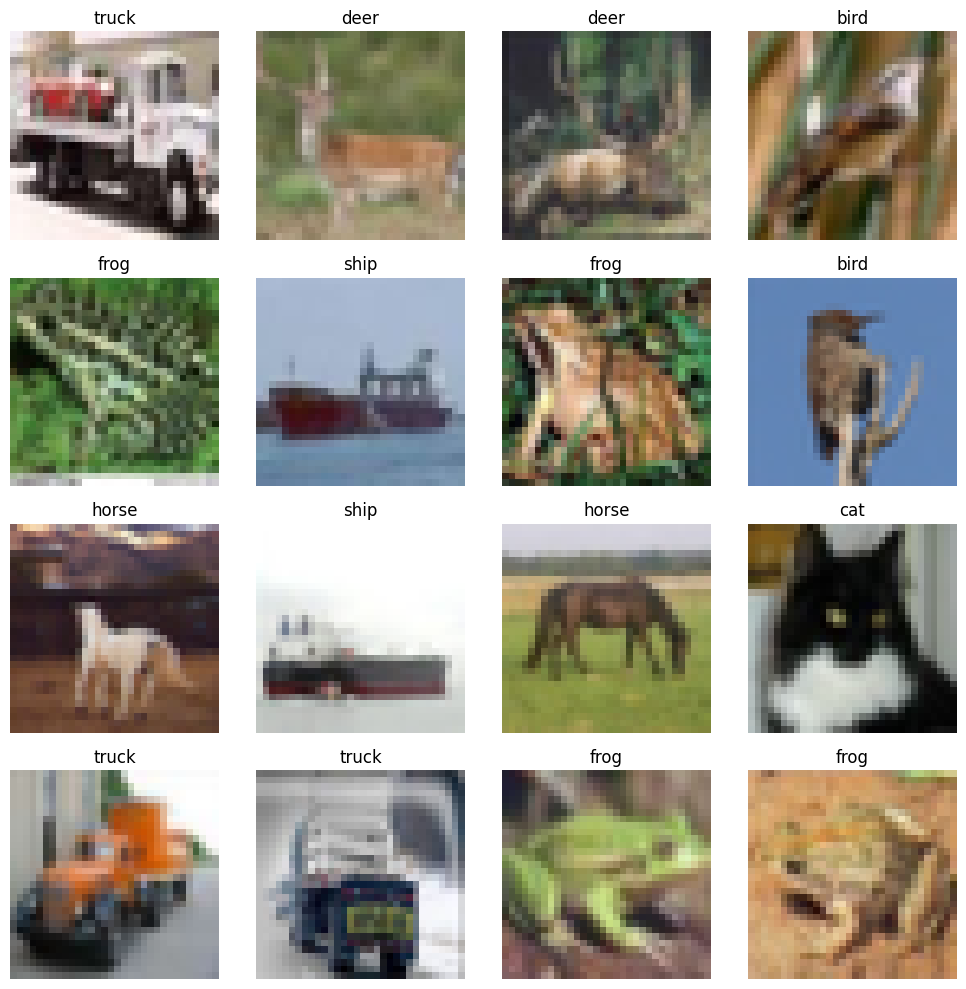


Dataset statistics:
Files already downloaded and verified
Class Distribution:
airplane: 5000
automobile: 5000
bird: 5000
cat: 5000
deer: 5000
dog: 5000
frog: 5000
horse: 5000
ship: 5000
truck: 5000


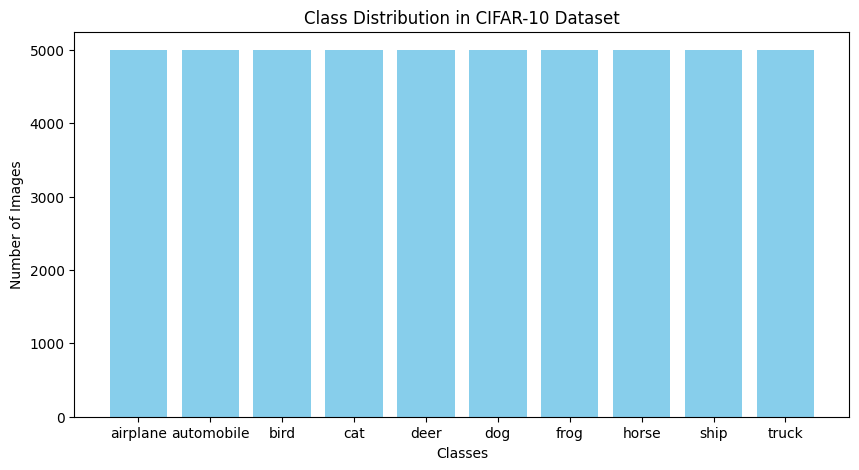

In [ ]:
# Visualize 16 random images from the dataset.
def visualize_raw_dataset(num_samples=16):

    # Load the raw CIFAR-10 dataset.
    raw_dataset = datasets.CIFAR10(root='./data/cifar10', train=True, download=True)
    images, labels = raw_dataset.data, raw_dataset.targets
    classes = raw_dataset.classes

    # Randomly select images.
    indices = random.sample(range(len(images)), num_samples)
    selected_images = [images[i] for i in indices]
    selected_labels = [labels[i] for i in indices]

    # Plot grid of images.
    fig, axes = plt.subplots(int(num_samples ** 0.5), int(num_samples ** 0.5), figsize=(10, 10))
    for img, lbl, ax in zip(selected_images, selected_labels, axes.ravel()):
        ax.imshow(img)
        ax.set_title(classes[lbl])
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Display dataset statistics (class distribution).
def dataset_statistics():

    # Load raw CIFAR-10 dataset.
    raw_dataset = datasets.CIFAR10(root='./data/cifar10', train=True, download=True)
    labels = raw_dataset.targets
    classes = raw_dataset.classes

    # Count images per class.
    class_counts = [labels.count(i) for i in range(len(classes))]

    # Print class distribution.
    print("Class Distribution:")
    for cls, count in zip(classes, class_counts):
        print(f"{cls}: {count}")

    # Plot class distribution.
    plt.figure(figsize=(10, 5))
    plt.bar(classes, class_counts, color='skyblue')
    plt.title("Class Distribution in CIFAR-10 Dataset")
    plt.xlabel("Classes")
    plt.ylabel("Number of Images")
    plt.show()


# Print the ruslts of the previous two functions.
print("Visualizing raw dataset:")
visualize_raw_dataset(num_samples=16)

print("\nDataset statistics:")
dataset_statistics()

### Explanation
- **`visualize_raw_dataset`**:
  - Loads the CIFAR-10 dataset.
  - Randomly selects a specified number of images.
  - Displays the images in a grid format with their corresponding labels.

- **`dataset_statistics`**:
  - Counts the number of images in each class.
  - Prints the class distribution.
  - Displays a bar chart of the distribution.

These steps give us a better understanding of the dataset's structure and ensure there are no anomalies or imbalances before proceeding to training the model.




## Step 4: Implementing Early Stopping

### What is Early Stopping?
Early stopping helps prevent overfitting by halting training when the validation loss stops improving for a specified number of epochs.


In [ ]:
class EarlyStopping:

    def __init__(self, patience=5, verbose=False):
        """
        Args:
            patience (int): How many epochs to wait after last improvement.
            verbose (bool): If True, prints a message for each validation loss improvement.
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0  # Reset the counter if the loss improves.
            if self.verbose:
                print(f"Validation loss improved to {val_loss:.4f}")
        else:
            self.counter += 1
            if self.verbose:
                print(f"No improvement in validation loss for {self.counter} epoch(s)")
            if self.counter >= self.patience:
                self.early_stop = True

### Explanation
- **`patience`**: Number of epochs to wait after the last improvement in validation loss.
- **`verbose`**: Provides detailed messages about improvements or lack thereof.
- **`counter`**: Tracks how many consecutive epochs show no improvement.
- **`best_loss`**: Keeps track of the best validation loss observed so far.
- **`early_stop`**: Boolean flag to indicate if training should stop.

This class will be used during training to monitor validation loss and halt training when necessary. Let's move to defining the training loop!


## Step 5: Dataset Loading and Preprocessing

### Dataset Preparation
To train our model effectively, we need to preprocess the CIFAR-10 dataset and split it into training, validation, and test sets. Below is the function used to achieve this:




In [ ]:
def load_dataset(total_sample_size=10000, val_split=0.1, test_split=0.2):
    """
    Parameters:
    - total_sample_size: Total number of samples to use for all sets.
    - val_split: Fraction of total samples for the validation set.
    - test_split: Fraction of total samples for the test set.

    Returns:
    - train_set, val_set, test_set: Split datasets.
    - classes: List of class names.
    """
    dataset_path = './data/cifar10'

    # Define transformations.
    transform_train = transforms.Compose([
        transforms.RandomRotation(15),  # Randomly rotate images by up to 15 degrees.
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Randomly adjust brightness, contrast, saturation.
        transforms.Resize((224, 224)),  # Resize images to match ResNet-50 input.
        transforms.RandomCrop(224, padding=4),  # Crop with padding for augmentation.
        transforms.RandomHorizontalFlip(),  # Flip images horizontally.
        transforms.ToTensor(),  # Convert images to tensors.
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),  # Normalize to ImageNet mean and std.
    ])

    transform_test = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize images to match ResNet-50 input.
        transforms.ToTensor(),  # Convert images to tensors
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),  # Normalize to ImageNet mean and std.
    ])

    # Load CIFAR-10 dataset.
    full_dataset = datasets.CIFAR10(root=dataset_path, train=True, download=True, transform=transform_train)

    # Randomly select a subset.
    indices = torch.randperm(len(full_dataset))[:total_sample_size]
    subset = Subset(full_dataset, indices)

    # Calculate split sizes.
    test_size = int(total_sample_size * test_split)
    val_size = int(total_sample_size * val_split)
    train_size = total_sample_size - test_size - val_size

    # Split the dataset.
    train_set, val_set, test_set = random_split(subset, [train_size, val_size, test_size])

    # Update transformations for the test set.
    test_set.dataset.transform = transform_test

    return train_set, val_set, test_set, full_dataset.classes

### Explanation
- **Transformations**:
  - **`RandomRotation`**: Adds variety by rotating images.
  - **`ColorJitter`**: Adjusts brightness, contrast, and saturation to simulate different lighting conditions.
  - **`Resize`**: Ensures all images are the same size for the model input.
  - **`RandomCrop` and `RandomHorizontalFlip`**: Augment data by cropping and flipping images.
  - **`Normalize`**: Scales pixel values to match the distribution of the ImageNet dataset.

- **Dataset Splitting**:
  - A subset of the dataset is selected for faster training.
  - The dataset is split into training, validation, and test sets based on user-defined proportions.

This function ensures that the dataset is preprocessed and ready for training the ResNet50 model. Let’s move on to setting up the model!


## Step 6: Defining the Model

### What is ResNet50?
ResNet50 is a deep convolutional neural network with 50 layers, pre-trained on a large dataset (ImageNet). It is known for its residual connections, which help solve the vanishing gradient problem, allowing the network to be deep and effective.

We will fine-tune ResNet50 to adapt it to the CIFAR-10 dataset. Fine-tuning involves modifying the pre-trained model slightly to work well for our specific task while leveraging the knowledge it has already learned.





In [ ]:
def get_model(num_classes=10):
    """
    Parameters:
    - num_classes: Number of output classes.

    Returns:
    - model: Modified ResNet-50 model.
    """
    model = models.resnet50(weights='IMAGENET1K_V1') # Load ResNet50 pre-trained on ImageNet.

    # Replace the initial convolution layer to match CIFAR-10 input dimensions (3 channels).
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

    # Modify the fully connected (fc) layer for the target number of classes.
    model.fc = nn.Sequential(
    nn.Dropout(0.5), # Add dropout for regularization.
    nn.Linear(model.fc.in_features, num_classes) # Adjust output to match number of classes.
    )
    return model

### Explanation
- **`models.resnet50(weights='IMAGENET1K_V1')`**: Loads a ResNet50 model pre-trained on ImageNet.
- **`model.conv1`**: Updates the initial convolution layer to fit CIFAR-10's input image size.
- **`nn.Sequential`**: Replaces the fully connected layer:
  - **`nn.Dropout(0.5)`**: Adds regularization to prevent overfitting.
  - **`nn.Linear`**: Adjusts the output layer for the specified number of classes (e.g., 10 for CIFAR-10).

This function sets up a ResNet-50 model customized for CIFAR-10, ready for training with our dataset. Let’s proceed to the training loop!




## Step 7: Training and Evaluation

### Functions for Model Training and Evaluation
To train our model and evaluate its performance, we define two functions: `train` and `evaluate`. These functions handle the forward and backward passes, as well as the computation of metrics like loss and accuracy.

In [ ]:
def train(model, dataloader, criterion, optimizer, device):
  """
    Train the model for one epoch.

    Parameters:
    - model: The neural network to train.
    - dataloader: DataLoader for training data.
    - criterion: Loss function.
    - optimizer: Optimization algorithm.
    - device: Device to perform training on (CPU or GPU).

    Returns:
    - Average loss and accuracy for the epoch.
    """
    model.train() # Set the model to training mode.
    total_loss, correct, total = 0.0, 0, 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device) # Move data to the specified device.
        optimizer.zero_grad() # Reset gradients.
        outputs = model(inputs) # Forward pass.
        loss = criterion(outputs, labels)  # Compute the loss.
        loss.backward() # Backpropagation.
        optimizer.step()  # Update model weights.

        total_loss += loss.item() * inputs.size(0) # Accumulate loss for the epoch.
        _, predicted = torch.max(outputs, 1) # Get predictions.
        correct += (predicted == labels).sum().item() # Count correct predictions.
        total += labels.size(0)  # Count total samples.

    return total_loss / total, 100.0 * correct / total # Return average loss and accuracy.


def evaluate(model, dataloader, criterion, device):
  """
    Evaluate the model on validation or test data.

    Parameters:
    - model: The neural network to evaluate.
    - dataloader: DataLoader for validation or test data.
    - criterion: Loss function.
    - device: Device to perform evaluation on (CPU or GPU).

    Returns:
    - Average loss and accuracy for the evaluation.
    """
    model.eval() # Set the model to evaluation mode.
    total_loss, correct, total = 0.0, 0, 0

    with torch.no_grad(): # Disable gradient computation for evaluation.
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device) # Move data to the specified device.
            outputs = model(inputs) # Forward pass.
            loss = criterion(outputs, labels) # Compute the loss.

            total_loss += loss.item() * inputs.size(0) # Accumulate loss for the evaluation.
            _, predicted = torch.max(outputs, 1) # Get predictions.
            correct += (predicted == labels).sum().item() # Count correct predictions.
            total += labels.size(0) # Count total samples.

    return total_loss / total, 100.0 * correct / total # Return average loss and accuracy.

### Explanation
- **`train` Function**:
  - Puts the model in training mode (`model.train()`).
  - Processes data in batches using the `dataloader`.
  - Performs forward and backward passes, computes loss, and updates model parameters.
  - Computes and returns average loss and accuracy for the epoch.

- **`evaluate` Function**:
  - Puts the model in evaluation mode (`model.eval()`).
  - Processes data without computing gradients (`torch.no_grad()`), reducing memory usage and speeding up computation.
  - Computes loss and accuracy for validation or test data.

These functions form the backbone of the training loop, allowing us to monitor the model's performance over epochs. Let’s move on to integrating these into a complete training pipeline!


## Step 8: Training Over Epochs with Early Stopping
### Function for Training with Validation and Early Stopping
This function manages the training process over multiple epochs, integrating early stopping based on validation loss and saving the best model.


In [ ]:
def train_epochs(model, trainloader, valloader, criterion, optimizer, device, num_epochs, patience=5, scheduler=None):
    """
    Train the model with early stopping based on validation loss.

    Parameters:
    - model: The neural network model.
    - trainloader: DataLoader for training data.
    - valloader: DataLoader for validation data.
    - criterion: Loss function.
    - optimizer: Optimization algorithm.
    - device: Device to run training on (CPU or GPU).
    - num_epochs: Maximum number of epochs to train.
    - patience: Number of epochs to wait for improvement before stopping early.

    Returns:
    - train_losses: List of training losses for each epoch.
    - train_accuracies: List of training accuracies for each epoch.
    - val_losses: List of validation losses for each epoch.
    - val_accuracies: List of validation accuracies for each epoch.
    """
    best_val_loss = float('inf') # Initialize the best validation loss as infinity.
    train_losses, train_accuracies = [], [] # Lists to track training metrics.
    val_losses, val_accuracies = [], [] # Lists to track validation metrics.

    # Initialize early stopping
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}") # Print epoch number.

        # Training phase
        train_loss, train_accuracy = train(model, trainloader, criterion, optimizer, device)
        train_losses.append(train_loss) # Record training loss.
        train_accuracies.append(train_accuracy)  # Record training accuracy.

        # Validation phase
        val_loss, val_accuracy = evaluate(model, valloader, criterion, device)
        val_losses.append(val_loss) # Record validation loss.
        val_accuracies.append(val_accuracy) # Record validation accuracy.

        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

        # Save the best model
        if val_loss < best_val_loss: # Check if current validation loss is the best.
            best_val_loss = val_loss # Update the best validation loss.
            torch.save(model.state_dict(), 'best_model.pth') # Save the model's state.
            print("Best model saved.")

             # Step the learning rate scheduler
        if scheduler:
            scheduler.step() # Adjust the learning rate if a scheduler is used.

        # Check for early stopping
        early_stopping(val_loss) # Update early stopping with the current validation loss.
        if early_stopping.early_stop: # Stop training if the early stopping condition is met.
            print("Early stopping triggered. Stopping training.")
            break

    return train_losses, train_accuracies, val_losses, val_accuracies # Return all tracked metrics.

### Explanation
- **Training Phase**:
  - Calls the `train` function to compute training loss and accuracy for the current epoch.
  - Appends these metrics to `train_losses` and `train_accuracies`.

- **Validation Phase**:
  - Calls the `evaluate` function to compute validation loss and accuracy.
  - Appends these metrics to `val_losses` and `val_accuracies`.

- **Early Stopping**:
  - Monitors validation loss and stops training if no improvement is observed for `patience` epochs.

- **Learning Rate Scheduler**:
  - Adjusts the learning rate dynamically if a scheduler is provided.

- **Model Checkpointing**:
  - Saves the model state whenever a new best validation loss is observed.

This function ensures efficient and robust training by incorporating validation monitoring, learning rate adjustments, and early stopping mechanisms.


## Step 9: Visualizing Metrics

### Function for Plotting Training and Validation Metrics
To understand the performance of the model during training, we visualize metrics such as loss and accuracy for both the training and validation datasets over all epochs.


In [ ]:
def plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies):
    """
    Plot training and validation metrics (loss and accuracy) over epochs.

    Parameters:
    - train_losses: List of training losses.
    - train_accuracies: List of training accuracies.
    - val_losses: List of validation losses.
    - val_accuracies: List of validation accuracies.
    """
    epochs = range(1, len(train_losses) + 1) # Define the range of epochs.

    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1) # First subplot for loss.
    plt.plot(epochs, train_losses, label='Training Loss') # Plot training loss.
    plt.plot(epochs, val_losses, label='Validation Loss') # Plot validation loss.
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs Epochs')
    plt.legend()
    plt.grid() # Add grid for better readability.

    # Plot Accuracy
    plt.subplot(1, 2, 2) # Second subplot for accuracy.
    plt.plot(epochs, train_accuracies, label='Training Accuracy') # Plot training accuracy.
    plt.plot(epochs, val_accuracies, label='Validation Accuracy') # Plot validation accuracy.
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Epochs')
    plt.legend()
    plt.grid() # Add grid for better readability.

    plt.tight_layout() # Adjust subplots to fit in the figure.
    plt.show() # Display the plots.

### Explanation
- **Epochs**:
  - The x-axis represents the number of epochs, starting from 1 to the total number of epochs.

- **Loss Plot**:
  - Displays how the training and validation losses change over epochs.
  - Helps identify if the model is overfitting (e.g., training loss decreases but validation loss increases).

- **Accuracy Plot**:
  - Shows how training and validation accuracies evolve.
  - Provides insights into whether the model is improving its predictions over time.

- **Visualization Aids**:
  - **`grid()`**: Adds a grid to the plots for easier interpretation.
  - **`legend()`**: Differentiates between training and validation metrics.
  - **`tight_layout()`**: Ensures the subplots fit well within the figure.

This function provides a clear visual representation of the model's performance during training and validation, making it easier to diagnose issues and track progress.


## Step 10: Evaluating the Test Set

### Function for Evaluating the Test Set
After training and validating the model, the final step is to evaluate its performance on the test set. This helps gauge how well the model generalizes to unseen data.


In [ ]:
def evaluate_test_set(model, testloader, criterion, device):
    """
    Evaluate the model on the test set.

    Parameters:
    - model: The trained model.
    - testloader: DataLoader for test data.
    - criterion: Loss function.
    - device: Device to run evaluation on (CPU or GPU).

    Returns:
    - test_loss: Loss on the test set.
    - test_accuracy: Accuracy on the test set.
    """
    print("Evaluating on the test set...")
    test_loss, test_accuracy = evaluate(model, testloader, criterion, device) # Use the evaluate function.
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%") # Print the results.
    return test_loss, test_accuracy

### Explanation
- **`evaluate` Function**:
  - Used to calculate the test loss and accuracy. It operates similarly to the validation phase but on unseen test data.

- **Metrics**:
  - **`test_loss`**: Provides a measure of how well the model performs on the test set in terms of its loss function.
  - **`test_accuracy`**: Reflects the percentage of correct predictions on the test set.

- **Purpose**:
  - This step ensures the model's performance is assessed on data it has never seen, offering a reliable indication of how it will perform in real-world scenarios.

## Step 11: Main Script Execution

Files already downloaded and verified


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 153MB/s]


Epoch 1/30
Train Loss: 1.8183, Train Accuracy: 35.03%
Val Loss: 1.8587, Val Accuracy: 43.00%
Best model saved.
Validation loss improved to 1.8587
Epoch 2/30
Train Loss: 1.3026, Train Accuracy: 53.90%
Val Loss: 1.1172, Val Accuracy: 64.50%
Best model saved.
Validation loss improved to 1.1172
Epoch 3/30
Train Loss: 1.0515, Train Accuracy: 63.57%
Val Loss: 1.4218, Val Accuracy: 67.40%
No improvement in validation loss for 1 epoch(s)
Epoch 4/30
Train Loss: 0.8755, Train Accuracy: 70.30%
Val Loss: 0.9551, Val Accuracy: 67.70%
Best model saved.
Validation loss improved to 0.9551
Epoch 5/30
Train Loss: 0.7905, Train Accuracy: 72.94%
Val Loss: 1.5559, Val Accuracy: 57.60%
No improvement in validation loss for 1 epoch(s)
Epoch 6/30
Train Loss: 0.7205, Train Accuracy: 75.37%
Val Loss: 1.0817, Val Accuracy: 69.20%
No improvement in validation loss for 2 epoch(s)
Epoch 7/30
Train Loss: 0.6499, Train Accuracy: 77.76%
Val Loss: 0.8178, Val Accuracy: 72.30%
Best model saved.
Validation loss improved 

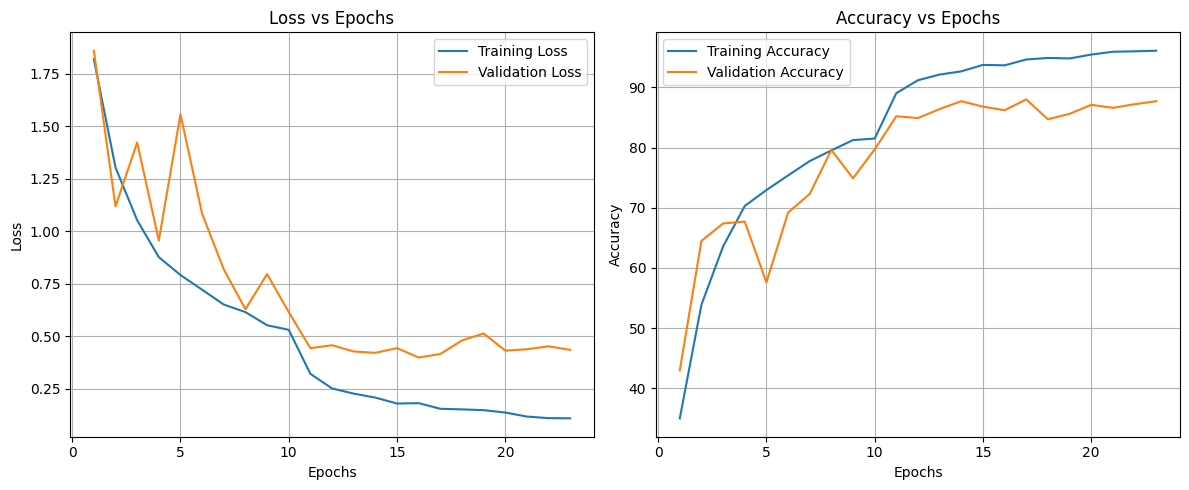

Evaluating on the test set...


<ipython-input-14-4758d23dd56c>:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Test Loss: 0.4296, Test Accuracy: 86.75%


In [ ]:
if __name__ == '__main__':
    # Parameters
    total_sample_size = 10000
    val_split = 0.1
    test_split = 0.2
    num_epochs = 30
    patience = 7
    batch_size = 32
    learning_rate = 0.01
    weight_decay = 5e-4
    momentum = 0.9

    # Load and preprocess dataset
    trainset, valset, testset, classes = load_dataset(
        total_sample_size=total_sample_size,
        val_split=val_split,
        test_split=test_split
    )
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    valloader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

    # Initialize model
    model = get_model(num_classes=len(classes)).to(device)

    # Define loss function, optimizer, and scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    # Train the model with early stopping and learning rate scheduler
    train_losses, train_accuracies, val_losses, val_accuracies = train_epochs(
    model, trainloader, valloader, criterion, optimizer, device, num_epochs, patience=patience, scheduler=scheduler
    )

    # Visualize metrics
    plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies)

    # Evaluate the best model on the test set
    model.load_state_dict(torch.load('best_model.pth'))
    evaluate_test_set(model, testloader, criterion, device)

### Explanation
- **Parameter Initialization**:
  - Specifies training parameters like batch size, learning rate, and number of epochs.

- **Dataset Loading**:
  - Calls `load_dataset` to prepare the training, validation, and test sets.
  - Wraps datasets in DataLoader objects for efficient batch processing.

- **Model Initialization**:
  - Uses `get_model` to create the ResNet model tailored for the CIFAR-10 dataset.

- **Training**:
  - Executes the `train_epochs` function to train the model with early stopping and learning rate adjustments.

- **Visualization**:
  - Calls `plot_metrics` to display training and validation performance trends.

- **Test Evaluation**:
  - Loads the best model from training and evaluates it on the test set using `evaluate_test_set`.

This main script ties all the components together, enabling the full training pipeline from data preparation to evaluation on the test set.


In [ ]:
import torch
from google.colab import files
from PIL import Image
from torchvision import transforms

## Step 12: Image Classification with Uploaded Images

### Code for Classifying Uploaded Images
This code allows you to upload images from outside the dataset, preprocess them, and classify them using the trained model.


In [ ]:
# Select the appropriate device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)  # Ensure the model is on the correct device

# Upload images using Google Colab's file upload utility
uploaded = files.upload()

# Preprocess the uploaded image
def preprocess_image(image_path):
    """
    Preprocess the uploaded image to match the CIFAR-10 dataset format.

    - Resizes the image to 32x32 (CIFAR-10 input size).
    - Converts the image to RGB format.
    - Normalizes the image to CIFAR-10's range (-1 to 1).
    """

    transform=transforms.Compose([
      transforms.Resize((224, 224)),  # Resize
      #transforms.Pad(4),            # Add padding if needed
      transforms.ToTensor(),
      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    # Open the image file
    img = Image.open(image_path).convert("RGB")  # Ensure 3 color channels (RGB)
    img = transform(img)  # Apply transformations
    img = img.unsqueeze(0)  # Add batch dimension (1, 3, 32, 32)
    return img

# Define CIFAR-10 class labels
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                'dog', 'frog', 'horse', 'ship', 'truck']

# Predict the class of the uploaded image
for filename in uploaded.keys():
    # Preprocess the image
    processed_image = preprocess_image(filename)
    processed_image = processed_image.to(device)  # Ensure the image is on the correct device

    # Perform inference
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculations for inference
        outputs = model(processed_image)  # Forward pass
        predicted_class = torch.argmax(outputs, axis=1).item()  # Get the predicted class index

    # Print the predicted class label
    print(f"Image: {filename} - Predicted Class: {class_labels[predicted_class]}")

Saving cat.jpeg to cat.jpeg
Image: cat.jpeg - Predicted Class: cat


### Explanation
- **Image Upload**:
  - Uses Colab's `files.upload()` utility to allow users to upload images for classification.

- **Preprocessing**:
  - Resizes the image to 224x224 to match ResNet-50 input dimensions.
  - Converts the image to a tensor and normalizes it to ImageNet statistics.

- **Inference**:
  - Sets the model to evaluation mode with `model.eval()`.
  - Uses `torch.no_grad()` to prevent gradient computation during inference.

- **Output**:
  - Predicts the class index using `torch.argmax`.
  - Maps the index to the class label using `class_labels` and prints the result.
  - Confirms if the prediction was correct when the image is classified as a "cat".


This implementation enables seamless classification of images uploaded via Google Colab.


## Step 14: Discussion of Results

### Training and Validation Performance
The model was trained for 23 epochs before early stopping was triggered, as the validation loss did not improve for 7 consecutive epochs. Key metrics from the training process:
- Final **Training Loss**: 0.1080
- Final **Validation Loss**: 0.4342
- Final **Training Accuracy**: 96.09%
- Final **Validation Accuracy**: 87.70%

These results indicate that the model was able to generalize well, achieving a high validation accuracy while maintaining a relatively low validation loss.

### Loss and Accuracy Trends
The plots show:
1. **Loss vs. Epochs**:
   - Training loss decreases steadily, indicating effective learning.
   - Validation loss decreases initially but plateaus after several epochs, suggesting the model reached its optimal performance early.
2. **Accuracy vs. Epochs**:
   - Training accuracy improves consistently, reaching 96%.
   - Validation accuracy follows a similar trend but stabilizes at 87.70%, showing good generalization.

### Test Set Evaluation
On the unseen test set, the model achieved:
- **Test Loss**: 0.4296
- **Test Accuracy**: 86.75%

This performance demonstrates that the model maintains its generalization capabilities even on new data, with only a slight drop in accuracy compared to the validation set.

### Summary
- **Strengths**:
  - The model achieves high accuracy on both validation and test sets, indicating strong generalization.
  - Early stopping prevented overfitting, as evidenced by the stable validation loss.

- **Limitations**:
  - The validation loss plateau suggests limited further improvement, which could be due to the dataset complexity or model capacity.

These results demonstrate the effectiveness of the model and training pipeline, showcasing its suitability for image classification tasks.
